In [2]:
using LinearAlgebra, Distributions, Statistics, Plots, Interpolations, NLsolve, Roots, QuadGK, LaTeXStrings, Plots.PlotMeasures, Base.Threads

Expected Value: 0.2652210580727446
Variance: 0.05705372038412834


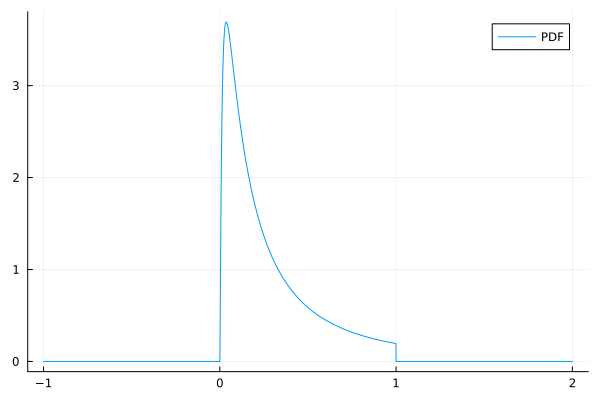

In [3]:
# Define the truncated log-normal PDF function
function truncated_lognormal(μₓ, σₓ)
    # Calculate log-space parameters
    μₓ_log = log(μₓ) - 0.5 * σₓ^2  # Mean in log-space
    σₓ_log = sqrt(log(1 + (σₓ^2 / μₓ^2))) # Standard deviation in log-space
    
    # Create the log-normal distribution
    lognormal_dist = LogNormal(μₓ_log, σₓ_log)
    
    # Precompute normalization factor
    cdf_low = cdf(lognormal_dist, 0)
    cdf_high = cdf(lognormal_dist, 1)
    normalization = cdf_high - cdf_low
    
    # Define the PDF function g
    g = x -> begin
        if x < 0 || x > 1
            return 0.0
        end
        original_pdf = pdf(lognormal_dist, x)
        return original_pdf / normalization
    end
    
    # Define the CDF function G
    G = x -> begin
        if x < 0
            return 0.0
        elseif x > 1
            return 1.0
        end
        original_cdf = cdf(lognormal_dist, x)
        return (original_cdf - cdf_low) / normalization
    end
    
    return g, G
end

# Parameters
μₓ = 0.3
σₓ = 0.7

g, G = truncated_lognormal(μₓ, σₓ)

# Function to calculate expected value and variance of a PDF
function calculate_moments(g, a, b)
    # Expected value (mean)
    expected_value, _ = quadgk(x -> x * g(x), a, b)
    
    # Second moment
    second_moment, _ = quadgk(x -> x^2 * g(x), a, b)
    
    # Variance
    variance = second_moment - expected_value^2
    
    return expected_value, variance
end

a, b = -1, 2  # Truncated domain [a, b]
mean, var = calculate_moments(g , a, b)

println("Expected Value: $mean")
println("Variance: $var")

plot(x -> g(x), a, b, label="PDF")

In [4]:
# Define the Bellman problem for J(x), W(x), and U
mutable struct JobMarketProblem
    p::Float64           # Productivity
    b::Float64           # Unemployment benefits
    c::Float64           # Job creation cost
    r::Float64           # Discount rate
    λ::Float64           # Job separation rate
    β::Float64           # Bargaining power of workers
    η::Float64           # Elasticity of matching function
    θ::Float64           # Tightness (to be updated during iteration)
    R::Float64           # Reservation productivity
    G::Function          # CDF of x
    g::Function          # PDF of x
    grid_x::Vector{Float64}  # Grid for x
    A::Float64           # Matching technology
end

struct GridSizes
    x_grid::Int
    p_grid::Int
end

const grid_sizes = GridSizes(100, 50)

GridSizes(100, 50)

In [5]:
# Productivity distribution
function truncated_lognormal(μₓ, σₓ)
    # Calculate log-space parameters
    μₓ_log = log(μₓ) - 0.5 * σₓ^2  # Mean in log-space
    σₓ_log = sqrt(log(1 + (σₓ^2 / μₓ^2))) # Standard deviation in log-space
    
    # Create the log-normal distribution
    lognormal_dist = LogNormal(μₓ_log, σₓ_log)
    
    # Precompute normalization factor
    cdf_low = cdf(lognormal_dist, 0)
    cdf_high = cdf(lognormal_dist, 1)
    normalization = cdf_high - cdf_low
    
    # Define the PDF function g
    g = x -> begin
        if x < 0 || x > 1
            return 0.0
        end
        original_pdf = pdf(lognormal_dist, x)
        return original_pdf / normalization
    end
    
    # Define the CDF function G
    G = x -> begin
        if x < 0
            return 0.0
        elseif x > 1
            return 1.0
        end
        original_cdf = cdf(lognormal_dist, x)
        return (original_cdf - cdf_low) / normalization
    end
    
    return g, G
end

truncated_lognormal (generic function with 1 method)

In [6]:
# Beta distribution PDF and CDF functions
function truncated_beta(α, β)
    beta_dist = Beta(α, β)

    # PDF function ℓ(x), returns 0 outside [0,1]
    ℓ = x -> begin
        (x < 0 || x > 1) ? 0.0 : pdf(beta_dist, x)
    end

    # CDF function L(x), clamped to [0,1]
    L = x -> begin
        if x < 0
            return 0.0
        elseif x > 1
            return 1.0
        end
        return cdf(beta_dist, x)
    end

    return ℓ, L
end

truncated_beta (generic function with 1 method)

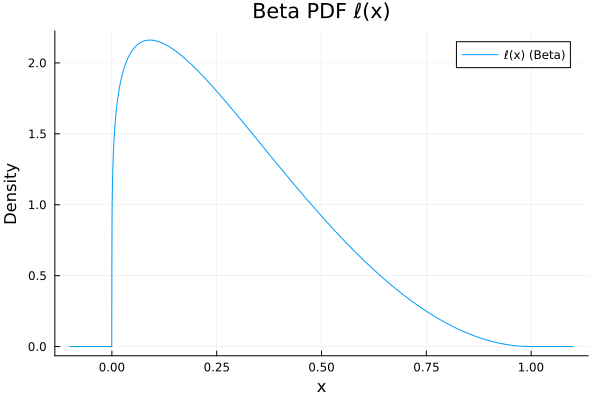

In [7]:
ℓ = truncated_beta(1.2, 3)[1]
plot(x -> ℓ(x), -0.1, 1.1, label="ℓ(x) (Beta)", legend=:topright,
     xlabel="x", ylabel="Density", title="Beta PDF ℓ(x)")

In [8]:
# Wage function
function wage(x, p, b, β, θ, c)
   return β * p * (x + c * θ) + (1 - β) * b
end

# Iterate the Value functions for J(x) and W(x)
function iterate_values(p::JobMarketProblem, J::Vector{Float64}, W::Vector{Float64}, U::Float64)
    nx = grid_sizes.x_grid
    new_J = zeros(nx)
    new_W = zeros(nx)
    
    @threads for i in 1:nx
        x = p.grid_x[i]
        w = wage(x, p.p, p.b, p.β, p.θ, p.c)
        
        # Value function for J(x)
        integral_term_J = sum(p.g(z) * J[j] for (j, z) in enumerate(p.grid_x) if z >= p.R) * (p.grid_x[2] - p.grid_x[1])
        new_J[i] = (p.p * x - w + p.λ * (-J[i] + integral_term_J))/p.r
        
        # Value function for W(x)
        integral_term_W = sum(p.g(z) * W[j] for (j, z) in enumerate(p.grid_x) if z >= p.R) * (p.grid_x[2] - p.grid_x[1])
        new_W[i] = (w + p.λ * (-W[i] + p.G(p.grid_x[i]) * U + integral_term_W))/p.r
    end
    
    return new_J, new_W
end

iterate_values (generic function with 1 method)

## Iterate U according to 
$$
rU = b + \theta q(\theta) \left( W(1) - U\right)
$$

Converged after 61 iterations with distance 9.598988270909103e-13


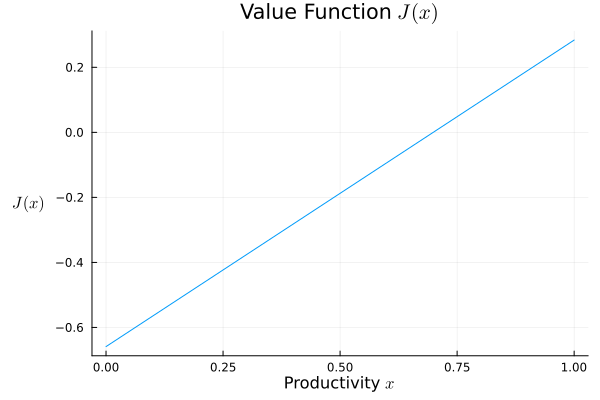

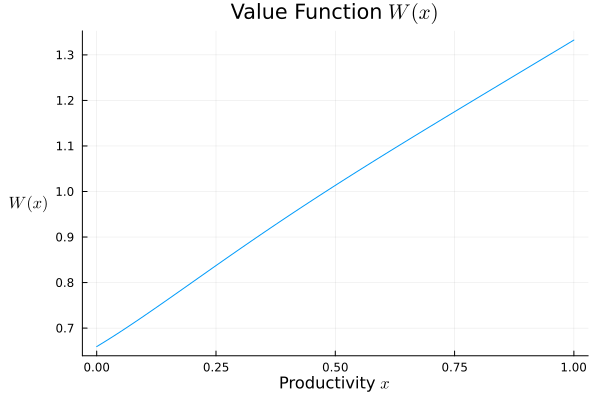

Computed value of unemployment U = 1.1429482497816579


In [9]:
# Iterate for U
function iterate_unemployment(p::JobMarketProblem, W::Vector{Float64}, U::Float64)
    W1 = W[end]  # x=1 corresponds to W(1)
    return (p.b + p.A * p.θ^(1-p.η) * (W1 - U))/p.r  # Using the Value function for U
end

# Solve the Value functions for J(x), W(x), and U
function solve_job_market_vfi(p::JobMarketProblem; maxiter::Int=10_000, tol::Float64=1e-12)
    nx = length(p.grid_x)
    J = zeros(nx)  
    W = zeros(nx)  
    U = p.b / p.r  # Initial guess for U
    
    for iter in 1:maxiter
        new_J, new_W = iterate_values(p, J, W, U)
        new_U = iterate_unemployment(p, new_W, U)
        
        # Convergence check
        distance = maximum(abs.([new_J; new_W; new_U] .- [J; W; U]))
        if distance < tol
            println("Converged after $iter iterations with distance $distance")
            return new_J, new_W, new_U
        end
        
        J, W, U = new_J, new_W, new_U
    end
    
    error("Value function iteration did not converge")
end

# Main function to set up the problem
function main_vfi()

    # Parameters
    p = 1.61    # General productivity
    μₓ = 2    # Mean of productivity distribution
    σₓ = 5   # Standard deviation of productivity distribution
    r = 0.9847  # Discount rate
    λ = 0.04  # Job separation rate
    c = 1.15  # Job creation cost
    b = 1.00  # Unemployment benefits
    β = 0.4  # Bargaining power of workers
    η = 0.77  # Elasticity of matching function
    θ = 0.10155018887627884 # Exogenous tightness
    R = 0.6986511976159954  # Exogenous Reservation productivity
    A = 1.12   # Matching technology

    # Grid for x
    nx = grid_sizes.x_grid
    grid_x = collect(range(0.0, 1.0, length=nx))
    
    # PDF and CDF of x 
    g, G = truncated_beta(μₓ, σₓ)

    # Create the problem
    problem = JobMarketProblem(p, b, c, r, λ, β, η, θ, R, G, g, grid_x, A)
    
    # Solve the problem
    J, W, U = solve_job_market_vfi(problem)
    
    # Plot the results
    J_plot = plot(grid_x, J, title=L"Value Function $J(x)$", xlabel=L"Productivity $x$", ylabel=L"$J(x)$", label="", yguidefontrotation=-90, left_margin = 8mm)
    #savefig("value_function_J.png")
    display(J_plot)
    
    W_plot = plot(grid_x, W, title=L"Value Function $W(x)$", xlabel=L"Productivity $x$", ylabel=L"$W(x)$", label="", yguidefontrotation=-90, left_margin = 8mm)
    #savefig("value_function_W.png")
    display(W_plot)
    
    println("Computed value of unemployment U = $U")
end

main_vfi()


This is quite unstable, takes ages to converge, and breaks down for large values of $\theta$, or even somewhat different values for other parameters too.

## Update U according to 
$$
rU = b + \frac{\beta}{1-\beta} \; pc \: \theta
$$

Converged after 10 iterations with distance 3.4705571749782393e-13


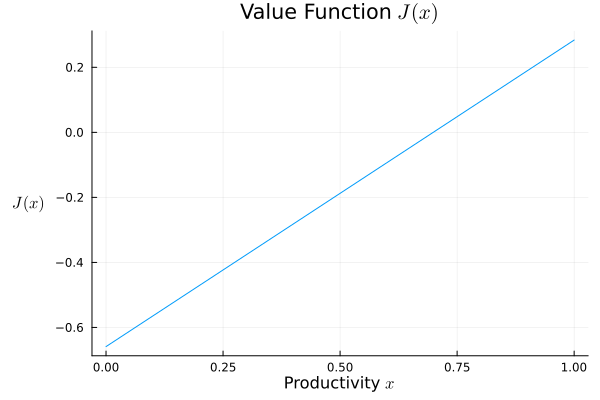

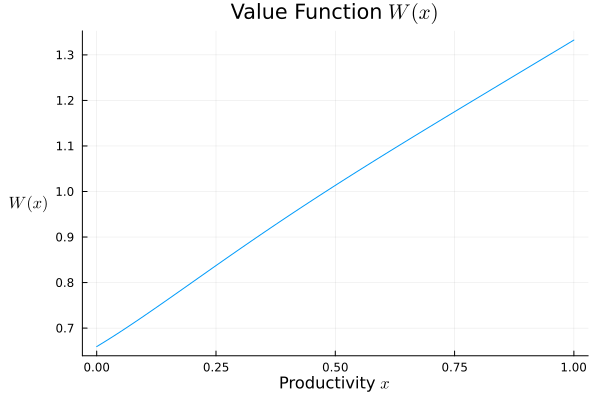

Computed value of unemployment U = 1.1428321144879525


In [10]:
# Update U
function update_unemployment(p::JobMarketProblem, U::Float64)
    return (p.b + (p.β / (1 - p.β)) * p.p * p.c * p.θ)/p.r
end

# Solve the Value functions for J(x), W(x), and U
function solve_job_market_vfi(p::JobMarketProblem; maxiter::Int=1_000, tol::Float64=1e-12)
    nx = length(p.grid_x)
    J = zeros(nx)
    W = zeros(nx)
    U = p.b / p.r  # Initial guess for U
    
    for iter in 1:maxiter
        new_J, new_W = iterate_values(p, J, W, U)
        new_U = update_unemployment(p, U)
        
        # Convergence check
        distance = maximum(abs.([new_J; new_W; new_U] .- [J; W; U]))
        if distance < tol
            println("Converged after $iter iterations with distance $distance")
            return new_J, new_W, new_U
        end
        
        J, W, U = new_J, new_W, new_U
    end
    
    error("Value function iteration did not converge")
end

# Main function to set up the problem
function main_vfi()
    # Parameters
    p = 1.61    # General productivity
    μₓ = 2    # Mean of productivity distribution
    σₓ = 5   # Standard deviation of productivity distribution
    r = 0.9847  # Discount rate
    λ = 0.04  # Job separation rate
    c = 1.15  # Job creation cost
    b = 1.00  # Unemployment benefits
    β = 0.4  # Bargaining power of workers
    η = 0.77  # Elasticity of matching function
    θ = 0.10155018887627884  # Exogenous tightness
    R = 0.6986511976159954  # Exogenous Reservation productivity
    A = 1.12   # Matching technology
    
    # Grid for x
    nx = grid_sizes.x_grid
    grid_x = collect(range(0.0, 1.0, length=nx))

    # PDF and CDF of x (Beta distribution, truncated to [0, 1])
    g, G = truncated_beta(μₓ, σₓ)

    # Create the problem
    problem = JobMarketProblem(p, b, c, r, λ, β, η, θ, R, G, g, grid_x, A)
    
    # Solve the problem
    J, W, U = solve_job_market_vfi(problem)
    
    # Plot the results
    J_plot = plot(grid_x, J, title=L"Value Function $J(x)$", xlabel=L"Productivity $x$", ylabel=L"$J(x)$", label="", yguidefontrotation=-90, left_margin = 8mm)
    #savefig("value_function_J.png")
    display(J_plot)
    
    W_plot = plot(grid_x, W, title=L"Value Function $W(x)$", xlabel=L"Productivity $x$", ylabel=L"$W(x)$", label="", yguidefontrotation=-90, left_margin = 8mm)
    #savefig("value_function_W.png")
    display(W_plot)
    
    println("Computed value of unemployment U = $U")
end

main_vfi()

Inner loop converged after 9 iterations
Inner loop converged after 7 iterations
Inner loop converged after 6 iterations
Inner loop converged after 6 iterations
Inner loop converged after 6 iterations
Inner loop converged after 5 iterations
Inner loop converged after 5 iterations
Inner loop converged after 5 iterations
Inner loop converged after 5 iterations
Inner loop converged after 4 iterations
Inner loop converged after 4 iterations
Outer loop converged after 11 iterations with θ = 0.10145218496733892, R = 0.6988751579331237, u = 0.06275024833136542


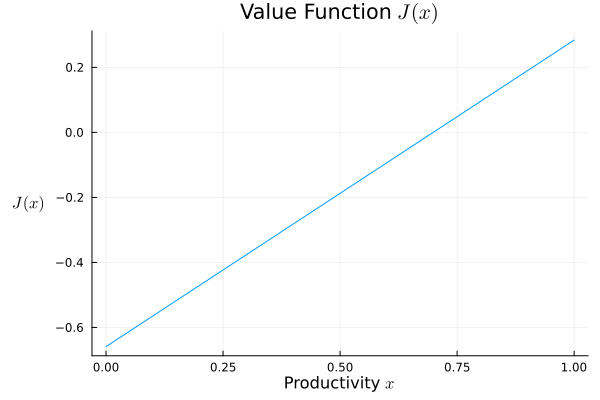

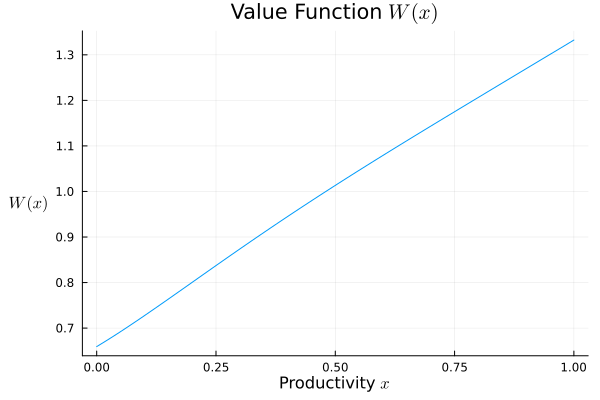

Value of unemployment U = 1.1427092238574055
Threshold productivity R = 0.6988751579331237
Labor market tightness θ = 0.10145218496733892
Equilibrium unemployment rate u = 0.06275024833136542


In [11]:
# Update R: Find where J(R) = 0 or approximate it
function find_R(J::Vector{Float64}, grid_x::Vector{Float64}, verbose::Bool=false)
    J_interp = LinearInterpolation(grid_x, J, extrapolation_bc=Line())
    if minimum(J) > 0
        if verbose
            println("J(x) > 0 on entire grid; setting R to max grid_x.")
        end
        return maximum(grid_x)
    elseif maximum(J) < 0
        if verbose
            println("J(x) < 0 on entire grid; setting R to min grid_x.")
        end
        return minimum(grid_x)
    else
        return find_zero(J_interp, (minimum(grid_x), maximum(grid_x)))  # Root-finding for J(R) = 0
    end
end

# Update θ: J(1) = p * c / q(θ) ↔ θ = ((pc) / (A J(1)))^(-1/η)
function find_θ(p::JobMarketProblem, J::Vector{Float64}, verbose::Bool=false)
    J1 = J[end]  # x=1 corresponds to the last grid point
    if J1 < 0
        if verbose
            println("J(1) is negative, setting J1 to a small positive value and updating θ.")
        end
        J1 = 1e-6  # Small positive number to replace negative J1
    end
    θ_new = (p.p * p.c / (p.A * J1))^(-1 / p.η)
    return θ_new
end

# Compute equilibrium unemployment rate
function compute_unemployment_rate(p::JobMarketProblem)
    G_R = p.G(p.R)  # CDF at R
    
    # If θ is zero, set the unemployment rate to 1
    if p.θ == 0
        return 1.0
    end
    
    q_theta = p.θ^(-p.η)  # q(θ)
    return p.λ * G_R / (p.λ * G_R + p.θ * q_theta)
end

function check_convergence!(in_a_row::Int, θ_current::Float64, θ_old::Float64, tol::Float64; threshold::Int=4)
    if abs(θ_current - θ_old) < tol
        in_a_row += 1
    else
        in_a_row = 0
    end
    return in_a_row >= threshold, in_a_row
end

# Iterate the Value functions for J(x) and W(x)
function solve_job_market_vfi(p::JobMarketProblem; max_outer_iter::Int=3_000, max_inner_iter::Int=100, tol::Float64=1e-6, 
                              verbose_model::Bool=false, verbose_vfi::Bool=false, verbose::Bool=false)
    nx = grid_sizes.x_grid
    J = zeros(nx)
    W = zeros(nx)
    U = p.b / p.r  # Initial guess for U
    θ_old = p.θ    # Initial guess for θ
    R_old = p.R    # Initial guess for R
    in_a_row_outer = 0  # Counter for consecutive convergence in the outer loop

    for outer_iter in 1:max_outer_iter
        try
            in_a_row_inner = 0  # Counter for consecutive convergence in the inner loop
            converged_inner = false
            
            # Inner loop: Solve for J(x), W(x), and U for a fixed θ
            for inner_iter in 1:max_inner_iter
                new_J, new_W = iterate_values(p, J, W, U)
                new_U = update_unemployment(p, U)

                # Convergence check for inner loop
                distance = maximum(abs.([new_J; new_W; new_U] .- [J; W; U]))
                converged_inner, in_a_row_inner = check_convergence!(in_a_row_inner, distance, 0.0, tol)
                if converged_inner
                    J, W, U = new_J, new_W, new_U
                    if verbose_vfi
                        println("Inner loop converged after $inner_iter iterations")
                    end
                    break
                end

                J, W, U = new_J, new_W, new_U
            end

            if !converged_inner
                error("Inner loop did not converge after $max_inner_iter iterations in outer iteration $outer_iter")
            end

            # Update R: Find the point where J(R) = 0
            p.R = find_R(J, p.grid_x, verbose)  # Root-finding for J(R) = 0

            # Update θ: J(1) = p * c / q(θ)
            p.θ = find_θ(p, J, verbose)

            # Compute unemployment rate
            u = compute_unemployment_rate(p)

            # Convergence check for θ
            converged, in_a_row_outer = check_convergence!(in_a_row_outer, p.θ, θ_old, tol)
            if converged
                if verbose_model
                    println("Outer loop converged after $outer_iter iterations with θ = $(p.θ), R = $(p.R), u = $u")
                end

                return J, W, U, p.R, p.θ, u
            end

            θ_old = p.θ
            R_old = p.R

        catch e
            error("Outer loop terminated early due to inner loop failure: $(e.msg)")
        end
    end

    error("Outer loop did not converge after $max_outer_iter iterations")
end

# Main function to set up the problem
function main_vfi(verbose_model::Bool=false, verbose_vfi::Bool=false, verbose::Bool=false)
    # Parameters
    p = 1.61    # General productivity
    μₓ = 2    # Mean of productivity distribution
    σₓ = 5   # Standard deviation of productivity distribution
    r = 0.9847  # Discount rate
    λ = 0.04  # Job separation rate
    c = 1.15  # Job creation cost
    b = 1.00  # Unemployment benefits
    β = 0.4  # Bargaining power of workers
    η = 0.77  # Elasticity of matching function
    θ = 0.1  # Initial guess for tightness
    R = 0.6  # Initial guess for Reservation productivity
    A = 1.12   # Matching technology

    # Grid for x
    nx = grid_sizes.x_grid
    grid_x = collect(range(0.0, 1.0, length=nx))

    # PDF and CDF of x (log-normal distribution, truncated to [0, 1])
    g, G = truncated_beta(μₓ, σₓ)

    # Create the problem
    problem = JobMarketProblem(p, b, c, r, λ, β, η, θ, R, G, g, grid_x, A)

    # Solve the problem
    J, W, U, R, θ, u = solve_job_market_vfi(problem, verbose_model=verbose_model, verbose_vfi=verbose_vfi, verbose=verbose)

    # Plot the results
    J_plot = plot(grid_x, J, 
        title=L"Value Function $J(x)$", 
        xlabel=L"Productivity $x$", 
        ylabel=L"$J(x)$", label="", 
        yguidefontrotation=-90, 
        left_margin = 8mm
    )
    display(J_plot)
    
    W_plot = plot(grid_x, W, 
        title=L"Value Function $W(x)$", 
        xlabel=L"Productivity $x$", 
        ylabel=L"$W(x)$", label="", 
        yguidefontrotation=-90, 
        left_margin = 8mm
    )
    display(W_plot)

    println("Value of unemployment U = $U")
    println("Threshold productivity R = $R")
    println("Labor market tightness θ = $θ")
    println("Equilibrium unemployment rate u = $u")
end

# Call with verbosity levels
main_vfi(true, true, true)

Inner loop converged after 9 iterations
Inner loop converged after 8 iterations
Inner loop converged after 7 iterations
Inner loop converged after 6 iterations
Inner loop converged after 5 iterations
Inner loop converged after 4 iterations
Inner loop converged after 4 iterations
Inner loop converged after 4 iterations
Outer loop converged after 8 iterations with θ = 0.014059656665997705, R = 0.6318253680088952, u = 0.09392773991112179


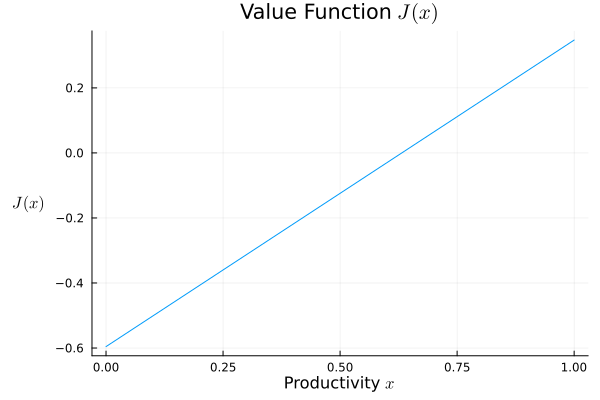

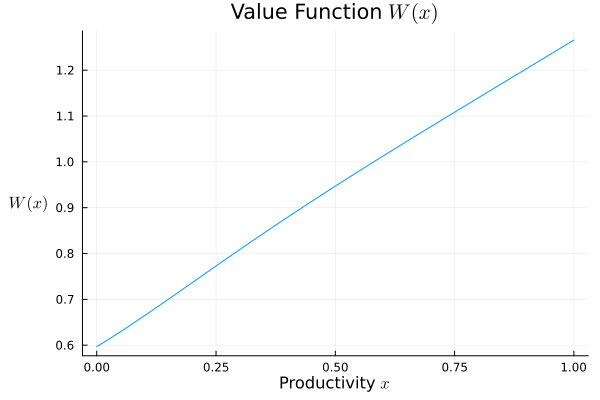

Value of unemployment U = 1.033161676516472
Threshold productivity R = 0.6318253680088952
Labor market tightness θ = 0.014059656665997705
Equilibrium unemployment rate u = 0.09392773991112179


In [12]:
# Update R: Find where J(R) = 0 or approximate it
function find_R(J::Vector{Float64}, grid_x::Vector{Float64}, verbose::Bool=false)
    J_interp = LinearInterpolation(grid_x, J, extrapolation_bc=Line())
    if minimum(J) > 0
        if verbose
            println("J(x) > 0 on entire grid; setting R to max grid_x.")
        end
        return maximum(grid_x)
    elseif maximum(J) < 0
        if verbose
            println("J(x) < 0 on entire grid; setting R to min grid_x.")
        end
        return minimum(grid_x)
    else
        return find_zero(J_interp, (minimum(grid_x), maximum(grid_x)))  # Root-finding for J(R) = 0
    end
end

# Update θ: J(1) = p * c / q(θ) ↔ θ = ((pc) / (A J(1)))^(-1/η)
function find_θ(p::JobMarketProblem, J::Vector{Float64}, verbose::Bool=false)
    J1 = J[end]  # x=1 corresponds to the last grid point
    if J1 < 0
        if verbose
            println("J(1) is negative, setting J1 to a small positive value and updating θ.")
        end
        J1 = 1e-6  # Small positive number to replace negative J1
    end
    θ_new = (p.p * p.c / (p.A * J1))^(-1 / p.η)
    return θ_new
end

# Compute equilibrium unemployment rate
function compute_unemployment_rate(p::JobMarketProblem)
    G_R = p.G(p.R)  # CDF at R
    
    # If θ is zero, set the unemployment rate to 1
    if p.θ == 0
        return 1.0
    end
    
    q_theta = p.θ^(-p.η)  # q(θ)
    return p.λ * G_R / (p.λ * G_R + p.θ * q_theta)
end

function check_convergence!(in_a_row::Int, θ_current::Float64, θ_old::Float64, tol::Float64; threshold::Int=4)
    if abs(θ_current - θ_old) < tol
        in_a_row += 1
    else
        in_a_row = 0
    end
    return in_a_row >= threshold, in_a_row
end

# Iterate the Value functions for J(x) and W(x)
function solve_job_market_vfi(p::JobMarketProblem; max_outer_iter::Int=3_000, max_inner_iter::Int=100, tol::Float64=1e-6, 
                              verbose_model::Bool=false, verbose_vfi::Bool=false, verbose::Bool=false)
    nx = grid_sizes.x_grid
    J = zeros(nx)
    W = zeros(nx)
    U = p.b / p.r  # Initial guess for U
    θ_old = p.θ    # Initial guess for θ
    R_old = p.R    # Initial guess for R
    in_a_row_outer = 0  # Counter for consecutive convergence in the outer loop

    for outer_iter in 1:max_outer_iter
        try
            in_a_row_inner = 0  # Counter for consecutive convergence in the inner loop
            converged_inner = false
            
            # Inner loop: Solve for J(x), W(x), and U for a fixed θ
            for inner_iter in 1:max_inner_iter
                new_J, new_W = iterate_values(p, J, W, U)
                new_U = update_unemployment(p, U)

                # Convergence check for inner loop
                distance = maximum(abs.([new_J; new_W; new_U] .- [J; W; U]))
                converged_inner, in_a_row_inner = check_convergence!(in_a_row_inner, distance, 0.0, tol)
                if converged_inner
                    J, W, U = new_J, new_W, new_U
                    if verbose_vfi
                        println("Inner loop converged after $inner_iter iterations")
                    end
                    break
                end

                J, W, U = new_J, new_W, new_U
            end

            if !converged_inner
                error("Inner loop did not converge after $max_inner_iter iterations in outer iteration $outer_iter")
            end

            # Update R: Find the point where J(R) = 0
            p.R = find_R(J, p.grid_x, verbose)  # Root-finding for J(R) = 0

            # Update θ: J(1) = p * c / q(θ)
            p.θ = find_θ(p, J, verbose)

            # Compute unemployment rate
            u = compute_unemployment_rate(p)

            # Convergence check for θ
            converged, in_a_row_outer = check_convergence!(in_a_row_outer, p.θ, θ_old, tol)
            if converged
                if verbose_model
                    println("Outer loop converged after $outer_iter iterations with θ = $(p.θ), R = $(p.R), u = $u")
                end

                return J, W, U, p.R, p.θ, u
            end

            θ_old = p.θ
            R_old = p.R

        catch e
            error("Outer loop terminated early due to inner loop failure: $(e.msg)")
        end
    end

    error("Outer loop did not converge after $max_outer_iter iterations")
end

# Main function to set up the problem
function main_vfi(verbose_model::Bool=false, verbose_vfi::Bool=false, verbose::Bool=false)
    # Parameters
    p = 1.61    # General productivity
    μₓ = 2    # Mean of productivity distribution
    σₓ = 5   # Standard deviation of productivity distribution
    r = 0.9847  # Discount rate
    λ = 0.04  # Job separation rate
    c = 1.15  # Job creation cost
    b = 1.00  # Unemployment benefits
    β = 0.4  # Bargaining power of workers
    η = 0.77  # Elasticity of matching function
    θ = 0.1  # Initial guess for tightness
    R = 0.6  # Initial guess for Reservation productivity
    A = 0.2   # Matching technology

    # Grid for x
    nx = grid_sizes.x_grid
    grid_x = collect(range(0.0, 1.0, length=nx))

    # PDF and CDF of x (Beta distribution, truncated to [0, 1])
    g, G = truncated_beta(μₓ, σₓ)

    # Create the problem
    problem = JobMarketProblem(p, b, c, r, λ, β, η, θ, R, G, g, grid_x, A)

    # Solve the problem
    J, W, U, R, θ, u = solve_job_market_vfi(problem, verbose_model=verbose_model, verbose_vfi=verbose_vfi, verbose=verbose)

    # Plot the results
    J_plot = plot(grid_x, J, 
        title=L"Value Function $J(x)$", 
        xlabel=L"Productivity $x$", 
        ylabel=L"$J(x)$", label="", 
        yguidefontrotation=-90, 
        left_margin = 8mm
    )
    display(J_plot)
    
    W_plot = plot(grid_x, W, 
        title=L"Value Function $W(x)$", 
        xlabel=L"Productivity $x$", 
        ylabel=L"$W(x)$", label="", 
        yguidefontrotation=-90, 
        left_margin = 8mm
    )
    display(W_plot)

    println("Value of unemployment U = $U")
    println("Threshold productivity R = $R")
    println("Labor market tightness θ = $θ")
    println("Equilibrium unemployment rate u = $u")
end

# Call with verbosity levels
main_vfi(true, true, true)

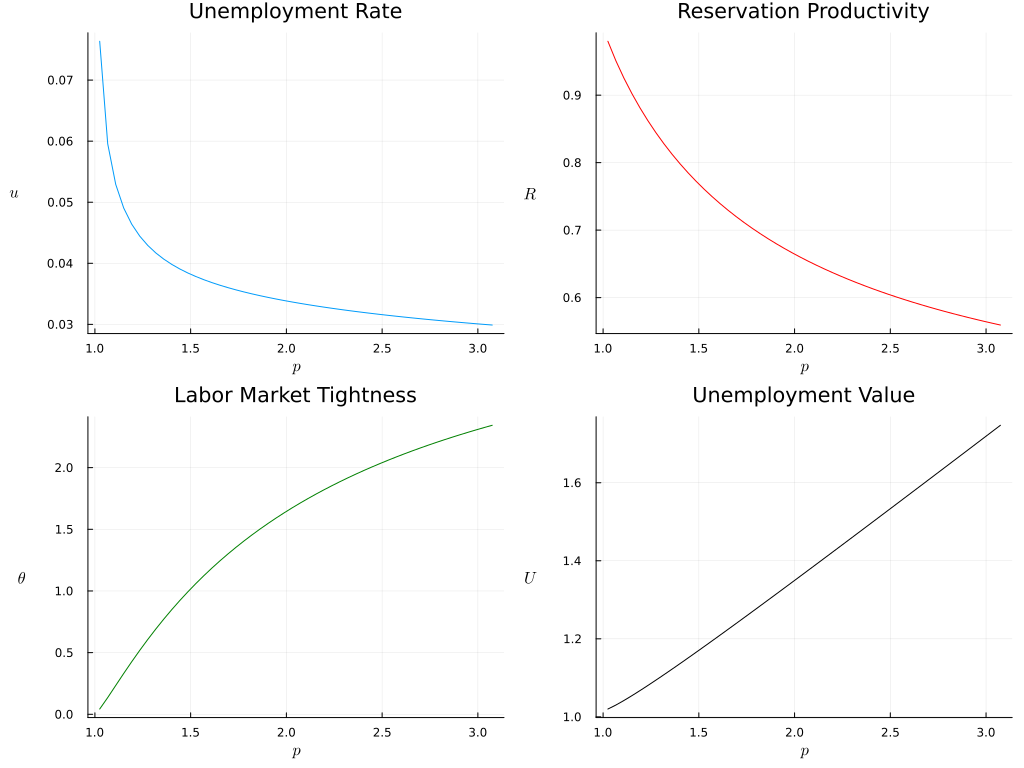

In [13]:
function p_plots(verbose_model::Bool=false, verbose_vfi::Bool=false, verbose::Bool=false)
    # Parameters (varying p around p_bar, plus and minus a percentage)
    p_bar = 2.05       # Example central value
    p_var_percent = 0.50     # percent variation over and under p
    μₓ = 2    # Mean of productivity distribution
    σₓ = 5   # Standard deviation of productivity distribution
    r = 0.9847  # Discount rate
    λ = 0.04  # Job separation rate
    c = 0.15  # Job creation cost
    b = 1.00  # Unemployment benefits
    β = 0.4  # Bargaining power of workers
    η = 0.77  # Elasticity of matching function
    θ = 0.1  # Initial guess for tightness
    R = 0.6  # Initial guess for Reservation productivity
    A = 1.12   # Matching technology

    # Grid for x
    nx = grid_sizes.x_grid
    grid_x = collect(range(0.0, 1.0, length=nx))

    # PDF and CDF of x (Beta distribution, truncated to [0, 1])
    g, G = truncated_beta(μₓ, σₓ)

    # Range of p values
    np = grid_sizes.p_grid
    p_values = collect(range(p_bar * (1 - p_var_percent), p_bar * (1 + p_var_percent), length=np))

    # Results storage
    results = Vector{Tuple{Float64, Float64, Float64, Float64, Float64}}(undef, length(p_values))

    # Parallel loop over p_values
    @threads for i in 1:length(p_values)
        p = p_values[i]
        # Create the problem for each p
        problem = JobMarketProblem(p, b, c, r, λ, β, η, θ, R, G, g, grid_x, A)

        # Solve the problem
        J, W, U, R, θ, u = solve_job_market_vfi(problem, verbose_model=verbose_model, verbose_vfi=verbose_vfi, verbose=verbose)

        # Store the results (unsorted)
        results[i] = (p, u, R, θ, U)
    end

    # Sort results by p values
    sorted_results = sort(results, by=x -> x[1])

    # Extract sorted data
    p_sorted = [x[1] for x in sorted_results]
    unemployment_rates = [x[2] for x in sorted_results]
    thresholds = [x[3] for x in sorted_results]
    labor_tightness = [x[4] for x in sorted_results]
    unemployment_values = [x[5] for x in sorted_results]

    # Plots
    # Plot for Unemployment Rate
    unemployment_plot = plot(
        p_sorted, 
        unemployment_rates, 
        label="", 
        xlabel=L"$p$", 
        ylabel=L"u",  
        title="Unemployment Rate", 
        yguidefontrotation=-90, 
        left_margin=6mm
    )

    # Plot for Threshold R
    threshold_plot = plot(
        p_sorted, 
        thresholds, 
        label="", 
        xlabel=L"$p$", 
        ylabel=L"R",  
        title="Reservation Productivity", 
        color="red", 
        yguidefontrotation=-90, 
        left_margin=6mm
    )

    # Plot for Labor Tightness
    tightness_plot = plot(
        p_sorted, 
        labor_tightness, 
        label="", 
        xlabel=L"$p$", 
        ylabel=L"\theta",  
        title="Labor Market Tightness", 
        color="green", 
        yguidefontrotation=-90, 
        left_margin=6mm
    )

    # Plot for Unemployment Value
    unemployment_value_plot = plot(
        p_sorted, 
        unemployment_values, 
        label="", 
        xlabel=L"$p$", 
        ylabel=L"U",  
        title="Unemployment Value", 
        color="black", 
        yguidefontrotation=-90, 
        left_margin=6mm
    )

    # Create a 2x2 grid layout
    plot_layout = @layout [grid(2, 2)]

    # Combine the plots into one figure with the layout
    combined_plot = plot(
        unemployment_plot, 
        threshold_plot, 
        tightness_plot, 
        unemployment_value_plot, 
        layout=plot_layout,
        size=(1024, 768),  
        legend=false     
    )

    # Display the combined plot
    display(combined_plot)
end

p_plots()


Comparing VFI with closed form with an exogenous theta to see if they get the same U.

Inner loop converged after 9 iterations
Inner loop converged after 8 iterations
Inner loop converged after 8 iterations
Inner loop converged after 8 iterations
Inner loop converged after 7 iterations
Inner loop converged after 7 iterations
Inner loop converged after 7 iterations
Inner loop converged after 6 iterations
Inner loop converged after 6 iterations
Inner loop converged after 6 iterations
Inner loop converged after 5 iterations
Inner loop converged after 5 iterations
Inner loop converged after 5 iterations
Inner loop converged after 4 iterations
Inner loop converged after 4 iterations
Inner loop converged after 4 iterations
Outer loop converged after 16 iterations with θ = 0.10145218141311113, R = 0.6988751660562119, u = 0.0627502488885443


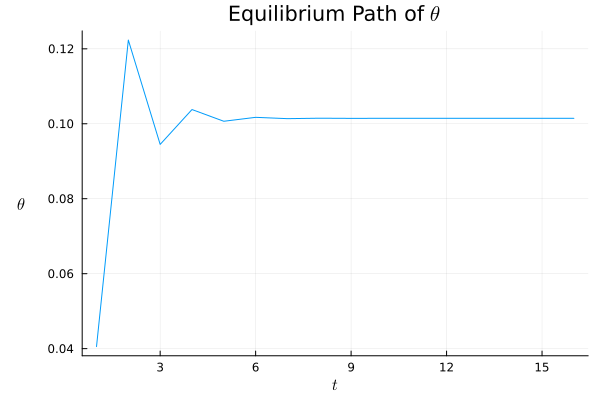

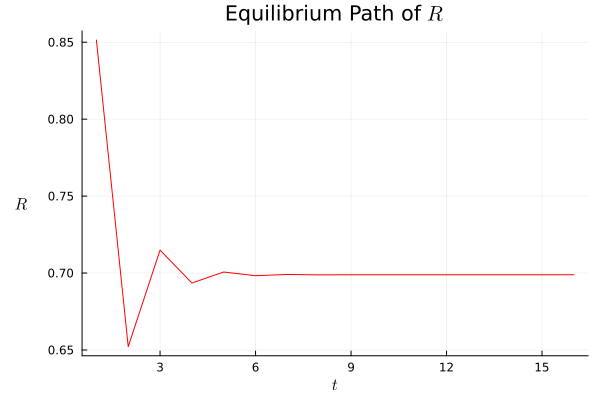

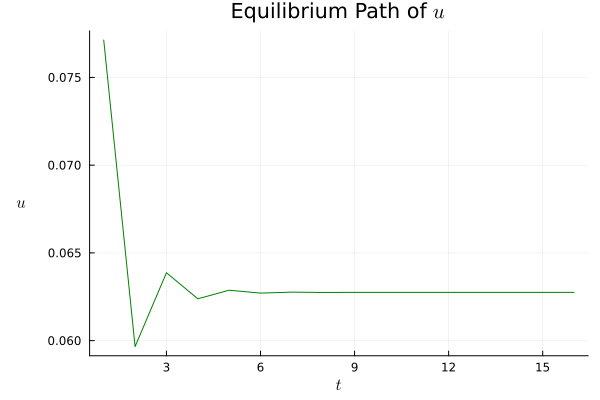

In Equilibrium:
θ = 0.10145218141311113
R = 0.6988751660562119
u = 0.0627502488885443


In [14]:
function solve_job_market_vfi_eq_path(p::JobMarketProblem; max_outer_iter::Int=100, max_inner_iter::Int=10_000, 
    tol::Float64=1e-6, verbose_model::Bool=false, verbose_vfi::Bool=false, verbose::Bool=false)

    K = length(p.grid_x)
    J = zeros(K)
    W = zeros(K)
    U = p.b / p.r  # Initial guess for U
    θ_old = p.θ    # Initial guess for θ
    R_old = p.R     # Initial guess for R
    in_a_row = 0    # Counter for consecutive convergence

    # Arrays to store the equilibrium paths
    θ_path = Float64[]
    R_path = Float64[]
    u_path = Float64[]

    for outer_iter in 1:max_outer_iter
        in_a_row_inner = 0  # Counter for inner loop convergence
        converged_inner = false

        # Inner loop: Solve for J(x), W(x), and U for a fixed θ
        for inner_iter in 1:max_inner_iter
            new_J, new_W = iterate_values(p, J, W, U)
            new_U = update_unemployment(p, U)

            # Convergence check for inner loop
            distance = maximum(abs.([new_J; new_W; new_U] .- [J; W; U]))
            converged_inner, in_a_row_inner = check_convergence!(in_a_row_inner, distance, 0.0, tol)
            if converged_inner
                J, W, U = new_J, new_W, new_U
                if verbose_vfi
                    println("Inner loop converged after $inner_iter iterations")
                end
                break
            end

            J, W, U = new_J, new_W, new_U
        end

        if !converged_inner
            error("Inner loop did not converge after $max_inner_iter iterations in outer iteration $outer_iter")
        end

        # Update R: Find the point where J(R) = 0
        p.R = find_R(J, p.grid_x, verbose)  # Root-finding for J(R) = 0

        # Update θ: J(1) = p * c / q(θ)
        p.θ = find_θ(p, J, verbose)

        # Compute unemployment rate
        u = compute_unemployment_rate(p)

        # Store the values of θ, R, and u at each iteration
        push!(θ_path, p.θ)
        push!(R_path, p.R)
        push!(u_path, u)

        # Convergence check for θ
        converged, in_a_row = check_convergence!(in_a_row, p.θ, θ_old, tol)
        if converged
            if verbose_model
                println("Outer loop converged after $outer_iter iterations with θ = $(p.θ), R = $(p.R), u = $u")
            end
            return J, W, U, p.R, p.θ, u, θ_path, R_path, u_path
        end
        
        θ_old = p.θ
        R_old = p.R
    end

    error("Outer loop did not converge")
end

function main_vfi_eq_path(verbose_model::Bool=false, verbose_vfi::Bool=false, verbose::Bool=false)
    # Parameters
    p = 1.61
    μₓ = 2    # Mean of productivity distribution
    σₓ = 5   # Standard deviation of productivity distribution
    r = 0.9847  # Discount rate
    λ = 0.04  # Job separation rate
    c = 1.15  # Job creation cost
    b = 1.00  # Unemployment benefits
    β = 0.4  # Bargaining power of workers
    η = 0.77  # Elasticity of matching function
    θ = 0.3  # Initial guess for tightness
    R = 0.6  # Initial guess for Reservation productivity
    A = 1.12   # Matching technology

    # Grid for x
    nx = grid_sizes.x_grid
    grid_x = collect(range(0.0, 1.0, length=nx))

    # PDF and CDF of x (log-normal distribution, truncated to [0, 1])
    g, G = truncated_beta(μₓ, σₓ)

    # Create the problem
    problem = JobMarketProblem(p, b, c, r, λ, β, η, θ, R, G, g, grid_x, A)

    # Solve the problem and store the entire equilibrium paths
    J, W, U, R, θ, u, θ_path, R_path, u_path = solve_job_market_vfi_eq_path(
        problem, verbose_model=verbose_model, verbose_vfi=verbose_vfi, verbose=verbose
    )

    # Plot the equilibrium path of θ
    θ_path_plot = plot(1:length(θ_path), θ_path, 
    label="", xlabel=L"t", ylabel=L"θ", 
    yguidefontrotation=-90, left_margin=6mm,
    title=L"Equilibrium Path of $\theta$"
    )
    display(θ_path_plot)

    # Plot the equilibrium path of R
    R_path_plot = plot(1:length(R_path), R_path,
    label="", xlabel=L"t", ylabel=L"R",
    yguidefontrotation=-90, left_margin=6mm,
    title=L"Equilibrium Path of $R$",
    color = "red"
    )
    display(R_path_plot)

    # Plot the equilibrium path of u
    u_path_plot = plot(1:length(u_path), u_path,
    label="", xlabel=L"t", ylabel=L"u",
    yguidefontrotation=-90, left_margin=6mm,
    title=L"Equilibrium Path of $u$",
    color = "green"
    )
    display(u_path_plot)

    # Optionally, print the final results
    if verbose
        println("In Equilibrium:")
        println("θ = $θ")
        println("R = $R")
        println("u = $u")
    end
end

# Call with verbosity levels
main_vfi_eq_path(true, true, true)

Starting pre-shock stabilization for 5 periods...
Pre-shock stabilization period 1: θ = 1.183988182747185, R = 0.7395069172210034
Pre-shock stabilization period 2: θ = 1.1839882616662019, R = 0.7395069038513171
Pre-shock stabilization period 3: θ = 1.1839882100005916, R = 0.7395069126039981
Pre-shock stabilization period 4: θ = 1.183988243824318, R = 0.739506906873914
Pre-shock stabilization period 5: θ = 1.1839882216810689, R = 0.7395069106252063
Pre-shock stabilization complete. Starting simulation with shock at period 8...
Period 1: θ = 1.183988236177505, u = 0.036849395372218936, R = 0.739506908169362
Period 2: θ = 1.183988226687178, u = 0.036849395443512345, R = 0.7395069097771202
Period 3: θ = 1.183988232900175, u = 0.03684939539683895, R = 0.7395069087245754
Period 4: θ = 1.1839882288327366, u = 0.036849395427394446, R = 0.739506909413641
Period 5: θ = 1.1839882314955494, u = 0.03684939540739081, R = 0.739506908962533
Period 6: θ = 1.1839882297522957, u = 0.036849395420486514, R

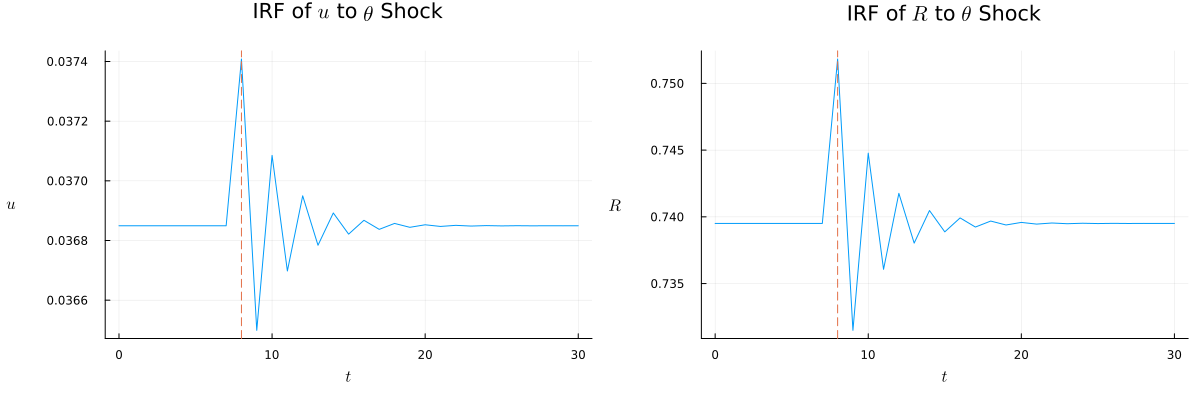

In equilibrium:
R = 0.7395068967988602
θ = 1.183981739769707
u = 0.036849444174786285


In [15]:
function simulate_model_dynamics_with_pre_shock(p::JobMarketProblem, J::Vector{Float64}, W::Vector{Float64}, U::Float64, R::Float64, 
    periods::Int, pre_shock_periods::Int, shock_time::Int, shock_size::Float64; 
    verbose_model::Bool=false, verbose::Bool=false)
    """
    Simulate the model to equilibrium, stabilize for pre_shock_periods, and apply a shock.

    Arguments:
        p::JobMarketProblem: Problem parameters.
        J, W, U, R: Initial values for equilibrium computation.
        periods::Int: Total simulation periods after recording starts.
        pre_shock_periods::Int: Periods to stabilize at equilibrium before recording.
        shock_time::Int: Time after recording starts when the shock hits.
        shock_size::Float64: Size of the shock (fractional change in θ).
        verbose_model::Bool: Verbosity for simulation progress.
        verbose::Bool: Verbosity for updates in `find_R` and `find_θ`.

    Returns:
        θ_path, u_path, R_path: Paths of labor market tightness (θ), unemployment rate (u), and reservation productivity (R).
    """
    # Pre-shock stabilization
    if verbose_model
        println("Starting pre-shock stabilization for $pre_shock_periods periods...")
    end

    for period in 1:pre_shock_periods
        # Update J, W, U to equilibrium
        J, W = iterate_values(p, J, W, U)
        U = update_unemployment(p, U)
        p.R = find_R(J, p.grid_x, verbose)  # Update R
        p.θ = find_θ(p, J, verbose)        # Update θ

        if verbose_model
            println("Pre-shock stabilization period $period: θ = $(p.θ), R = $(p.R)")
        end
    end

    if verbose_model
        println("Pre-shock stabilization complete. Starting simulation with shock at period $shock_time...")
    end

    # Start recording paths
    θ_path = [p.θ]
    u_path = [compute_unemployment_rate(p)]
    R_path = [p.R]

    # Simulate post-stabilization dynamics
    for t in 1:periods
        if t == shock_time
            if verbose_model
                println("Shock applied at period $t: θ changed by $(shock_size * 100)%")
            end
            p.θ *= (1 + shock_size)  # Apply shock to θ
        end

        # Update J, W, U
        J, W = iterate_values(p, J, W, U)
        U = update_unemployment(p, U)

        # Update R
        p.R = find_R(J, p.grid_x, verbose)

        # Update θ
        p.θ = find_θ(p, J, verbose)

        # Compute unemployment rate
        u = compute_unemployment_rate(p)

        push!(θ_path, p.θ)
        push!(u_path, u)
        push!(R_path, p.R)

        if verbose_model
            println("Period $t: θ = $(p.θ), u = $u, R = $(p.R)")
        end
    end

    return θ_path, u_path, R_path
end

function main_vfi_irf(verbose_model::Bool=false, verbose::Bool=false)
    # Parameters
    p = 1.61
    μₓ = 2    # Mean of productivity distribution
    σₓ = 5   # Standard deviation of productivity distribution
    r = 0.9847  # Discount rate
    λ = 0.04  # Job separation rate
    c = 0.15  # Job creation cost
    b = 1.00  # Unemployment benefits
    β = 0.4  # Bargaining power of workers
    η = 0.77  # Elasticity of matching function
    θ = 0.3  # Initial guess for tightness
    R = 0.6  # Initial guess for Reservation productivity
    A = 1.12   # Matching technology

    # Grid for x
    nx = grid_sizes.x_grid
    grid_x = collect(range(0.0, 1.0, length=nx))

    # PDF and CDF of x (Beta distribution, truncated to [0, 1])
    g, G = truncated_beta(μₓ, σₓ)

    # Create the problem
    problem = JobMarketProblem(p, b, c, r, λ, β, η, θ, R, G, g, grid_x, A)

    # Solve the problem to initial equilibrium
    J, W, U, R, θ_path, u_path = solve_job_market_vfi(problem)

    # Simulate model dynamics with a shock after pre-shock periods
    pre_shock_periods = 5  # Stabilization periods before starting recording
    periods = 30           # Total periods to record after stabilization
    shock_time = 8         # Time of shock after stabilization begins
    shock_size = 0.1       # 10% increase in θ
    θ_path_shock, u_path_shock, R_path_shock = simulate_model_dynamics_with_pre_shock(
        problem, J, W, U, R, periods, pre_shock_periods, shock_time, shock_size;
        verbose_model=verbose_model, verbose=verbose
    )

    # Plot the impulse response functions
    plot1 = plot(0:(periods), u_path_shock, label="", 
                 title=L"IRF of $u$ to $θ$ Shock", 
                 xlabel=L"t", ylabel=L"u", 
                 yguidefontrotation=-90, 
                 margin=8mm
                 )
    vline!(plot1, [shock_time], label="", linestyle=:dash)

    plot2 = plot(0:(periods), R_path_shock, label="", 
                 title=L"IRF of $R$ to $θ$ Shock", 
                 xlabel=L"t", ylabel=L"R",
                 yguidefontrotation=-90
                 )
    vline!(plot2, [shock_time], label="", linestyle=:dash)

    # Display the plots side by side
    display(plot(plot1, plot2, layout=(1, 2), legend=:topright, size=(1200, 400)))

    if verbose
        println("In equilibrium:")
        println("R = $R")
        println("θ = $(θ_path_shock[end])")
        println("u = $(u_path_shock[end])")
    end
end

# Call with verbosity levels
main_vfi_irf(true, true)

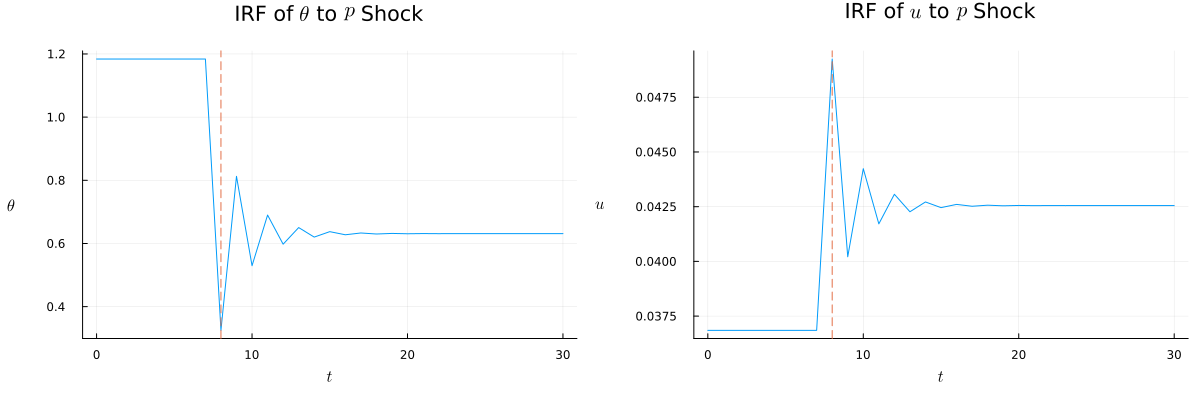

Shock to p: -20.0%
Before shock:
  θ = 1.1839882297522957
  u = 0.036849395420486514
After shock:
  θ = 0.6311759747052197
  u = 0.042550145955462484


In [16]:
function simulate_model_dynamics_with_pre_shock_p(p::JobMarketProblem, J::Vector{Float64}, W::Vector{Float64}, U::Float64, R::Float64, 
    periods::Int, pre_shock_periods::Int, shock_time::Int, shock_size::Float64; 
    verbose_model::Bool=false, verbose::Bool=false)
    """
    Simulate the model to equilibrium, stabilize for `pre_shock_periods`, and apply a shock to p.

    Arguments:
        p::JobMarketProblem: Problem parameters.
        J, W, U, R: Initial values for equilibrium computation.
        periods::Int: Total simulation periods after recording starts.
        pre_shock_periods::Int: Periods to stabilize at equilibrium before recording.
        shock_time::Int: Time after recording starts when the shock hits.
        shock_size::Float64: Size of the shock (fractional change in p).
        verbose_model::Bool: Verbosity for simulation progress.
        verbose::Bool: Verbosity for updates in `find_R` and `find_θ`.

    Returns:
        θ_path, u_path: Paths of labor market tightness (θ) and unemployment rate (u).
    """
    # Pre-shock stabilization
    if verbose_model
        println("Starting pre-shock stabilization for $pre_shock_periods periods...")
    end

    for period in 1:pre_shock_periods
        J, W = iterate_values(p, J, W, U)
        U = update_unemployment(p, U)
        p.R = find_R(J, p.grid_x, verbose)  # Update R
        p.θ = find_θ(p, J, verbose)        # Update θ

        if verbose_model
            println("Pre-shock stabilization period $period: θ = $(p.θ), R = $(p.R)")
        end
    end

    if verbose_model
        println("Pre-shock stabilization complete. Starting simulation with shock to $(p.p) at period $shock_time...")
    end

    # Start recording paths
    θ_path = [p.θ]
    u_path = [compute_unemployment_rate(p)]  # Track unemployment rate

    # Simulate post-stabilization dynamics
    for t in 1:periods
        if t == shock_time
            if verbose_model
                println("Shock applied at period $t: p changed by $(shock_size * 100)%")
            end
            p.p *= (1 + shock_size)  # Apply shock to p
        end

        # Update J, W, U
        J, W = iterate_values(p, J, W, U)
        U = update_unemployment(p, U)

        # Update R
        p.R = find_R(J, p.grid_x, verbose)

        # Update θ
        p.θ = find_θ(p, J, verbose)

        # Compute unemployment rate
        u = compute_unemployment_rate(p)

        # Record paths
        push!(θ_path, p.θ)
        push!(u_path, u)

        if verbose_model
            println("Period $t: θ = $(p.θ), u = $u, R = $(p.R)")
        end
    end

    return θ_path, u_path
end

function main_vfi_irf_p(verbose_model::Bool=false, verbose::Bool=false)
    # Parameters
    p = 1.61
    μₓ = 2
    σₓ = 5
    r = 0.9847
    λ = 0.04
    c = 0.15
    b = 1.00
    β = 0.4
    η = 0.77
    θ = 0.3
    R = 0.6
    A = 1.12

    nx = grid_sizes.x_grid
    grid_x = collect(range(0.0, 1.0, length=nx))
    g, G = truncated_beta(μₓ, σₓ)
    problem = JobMarketProblem(p, b, c, r, λ, β, η, θ, R, G, g, grid_x, A)

    J, W, U, R, θ_path, u_path = solve_job_market_vfi(problem)

    # Simulation parameters
    pre_shock_periods = 5
    periods = 30
    shock_time = 8
    shock_size = -0.20  # percentage shock to p

    θ_path_shock, u_path_shock = simulate_model_dynamics_with_pre_shock_p(
        problem, J, W, U, R, periods, pre_shock_periods, shock_time, shock_size; 
        verbose_model=verbose_model, verbose=verbose
    )

    # Plot the impulse response functions
    plot1 = plot(0:(periods), θ_path_shock, label="", 
                 title=L"IRF of $\theta$ to $p$ Shock", 
                 xlabel=L"t", ylabel=L"\theta", 
                 yguidefontrotation=-90, 
                 margin=8mm)
    vline!(plot1, [shock_time], label="", linestyle=:dash)

    plot2 = plot(0:(periods), u_path_shock, label="", 
                 title=L"IRF of $u$ to $p$ Shock", 
                 xlabel=L"t", ylabel=L"u",
                 yguidefontrotation=-90)
    vline!(plot2, [shock_time], label="", linestyle=:dash)

    display(plot(plot1, plot2, layout=(1, 2), legend=:topright, size=(1200, 400)))

    if verbose
        shock_percent = shock_size * 100
        println("Shock to p: $shock_percent%")
        println("Before shock:")
        println("  θ = $(θ_path_shock[shock_time - 1])")
        println("  u = $(u_path_shock[shock_time - 1])")
        println("After shock:")
        println("  θ = $(θ_path_shock[end])")
        println("  u = $(u_path_shock[end])")
    end
end

# Call with verbosity levels
main_vfi_irf_p(false, true)